In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
plt.rcParams['mathtext.fontset'] = 'stix'

from sgoopT import stationary, mu_factor, eigenval, sg_transmat, sgap
from cmap1dT import SgoopDistance
import scipy.optimize as opt

# Variables

In [2]:
# data:
filename={}
s={}
weights={}
mids={}
prob={}
freeE={}

# MD parameters:
T=400.0
beta=1000/(T*8.28) # kT=(8.28/1000)*T (kJ/mol/K)
Rout=100  # (unit: steps/lines)

# metaD parameters:
stride={}
wbias={}
delta_beta={}

# SGOOP parameters:
rc_bin={}
wells={}
th={}
coeff={}
rc={}
pi={}
MU={}
S={}
E={}
binedges={}


In [ ]:
# phi1 psi1 phi2 psi2 phi3 psi3
# skiprows=13
# 5000000 data points
# 1000 ns

# First SGOOP

### Read trajectory files

In [3]:
# Read unbiased data:
filename['unbiased']='./DATA_alatetra/Data1/unbiased/COLVAR'
data = np.loadtxt(filename['unbiased'], unpack=True, usecols=(1,3,5), skiprows=13)

(cos_phi1, sin_phi1), (cos_phi2, sin_phi2),  (cos_phi3, sin_phi3)

In [4]:
s['1']=np.vstack(( np.cos(data[0]), np.sin(data[0]),\
                   np.cos(data[1]), np.sin(data[1]),\
                   np.cos(data[2]), np.sin(data[2]) ))

### Exp(eigenvalues) and 0th eigenvectors of MaxCal-based rate matrix for optimal RC $\chi^{(1)}$

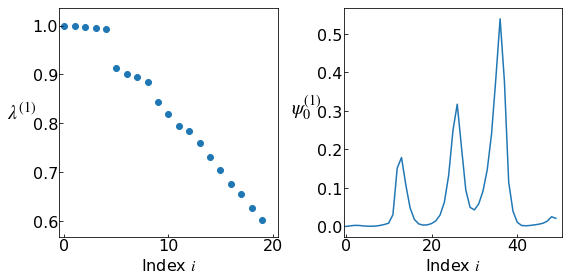

In [5]:
# parameters:
rc_bin['1']=50
# Optimal coefficients of linear combination found by SGOOP
coeff['1']=(0.18702148, -1.12682634, -0.22804864, -2.36242331, 0.22972807, 1.17576393)

# data:s
rc['unbiased'] = np.dot(coeff['1'], s['1'][:,:100000])
rc['1'] = np.dot(coeff['1'], s['1'])
pi['1'], binedges['1'] = stationary(rc['1'], rc_bin=rc_bin['1'])
MU['1'] = mu_factor(rc['unbiased'], pi['1'], binedges['1'], max_d=1)
S['1'] = sg_transmat(rc_bin['1'], pi['1'], MU['1'], max_d=1)
E['1'] = eigenval(S['1'])
eval1, exp_eval1, evec1 = E['1']
rate1 = -eval1

# Plottings:
fig, ax=plt.subplots(figsize=(8,4), nrows=1, ncols=2)

ax[0].scatter(np.arange(exp_eval1.shape[0]-30), exp_eval1[:20])
ax[1].plot(np.abs(evec1[:,0]))
           
ax[0].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[0].set_xlabel('Index $i$', size=16)
ax[0].set_ylabel('$\lambda^{(1)}$', size=20).set_rotation(0)
ax[0].yaxis.set_label_coords(-0.17, 0.5)
# ax[0].set_xlim(-0.5, rc_bin['1']+0.5)
ax[0].set_xlim(-0.5, 20.5)

ax[1].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[1].set_xlabel('Index $i$', size=16)
ax[1].set_ylabel('$\psi^{(1)}_0$', size=20).set_rotation(0)
ax[1].yaxis.set_label_coords(-0.17, 0.5)
ax[1].set_xlim(-0.5,rc_bin['1']+0.5)

fig.tight_layout()
plt.show()

# Second SGOOP

In [6]:
s['2']=s['1']

### Read trajectory files

In [7]:
filename['biased1']='./DATA_alatetra/Data1/biased1/COLVAR'
data_b1  = np.loadtxt(filename['biased1'], unpack=True, usecols=(1,2,3,4,5,6))

Calculate the w_arr1 as the inverse of marginal probability. We will weight our stationary density by w_arr1 to obtain conditional density.

In [8]:
binedges['1'][-1]+=1000
idx_arr = np.digitize(rc['1'], binedges['1'])-1
w_arr1=pi['1'][idx_arr]

### Exp(eigenvalues) and 0th eigenvectors of MaxCal-based rate matrix for optimal RC $\chi^{(2)}$

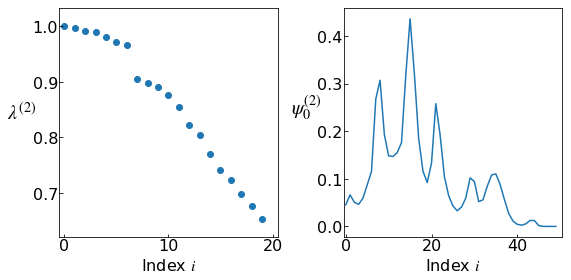

In [9]:
# parameters:
rc_bin['2']=50
# Optimal coefficients of linear combination found by SGOOP
coeff['2']=np.array([1.17386972, 0.73759148, 0.13155727, 0.71557062, 0.35587848, 2.82730112])

# data:
rc['unbiased']=np.dot(coeff['2'], data_b1[:,100000:200000])
rc['2'] = np.dot(coeff['2'], s['2'])
pi['2'], binedges['2'] = stationary(rc['2'], rc_bin=rc_bin['2'], weights=1/w_arr1)
MU['2'] = mu_factor(rc['unbiased'], pi['2'], binedges['2'], max_d=1)
S['2'] = sg_transmat(rc_bin['2'], pi['2'], MU['2'], max_d=1)
E['2'] = eigenval(S['2'])
eval2, exp_eval2, evec2 = E['2']
rate2 = -eval2

# Plottings:
fig, ax=plt.subplots(figsize=(8,4), nrows=1, ncols=2)

ax[0].scatter(np.arange(exp_eval2.shape[0]-30), exp_eval2[:20])
ax[1].plot(np.abs(E['2'][2][:,0]))

ax[0].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[0].set_xlabel('Index $i$', size=16)
ax[0].set_ylabel('$\lambda^{(2)}$', size=20).set_rotation(0)
ax[0].yaxis.set_label_coords(-0.17, 0.5)
ax[0].set_xlim(-0.5, 20.5)

ax[1].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[1].set_xlabel('Index $i$', size=16)
ax[1].set_ylabel('$\psi^{(2)}_0$', size=20).set_rotation(0)
ax[1].yaxis.set_label_coords(-0.17, 0.5)
ax[1].set_xlim(-0.5,rc_bin['2']+0.5)

fig.tight_layout()
plt.show()

# Third SGOOP

In [10]:
s['3']=s['2']

### Read trajectory files

In [11]:
filename['biased2']='./DATA_alatetra/Data1/biased2/COLVAR'
data_b2 = np.loadtxt(filename['biased2'], unpack=True, usecols=(1,2,3,4,5,6))

Later we will weight our stationary density by w_arr1*w_arr2 to obtain conditional density.

In [12]:
binedges['2'][-1]+=1000
idx_arr2 = np.digitize(rc['2'], binedges['2'])-1
w_arr2=pi['2'][idx_arr2]

### Exp(eigenvalues) and 0th eigenvectors of MaxCal-based rate matrix for optimal RC $\chi^{(3)}$

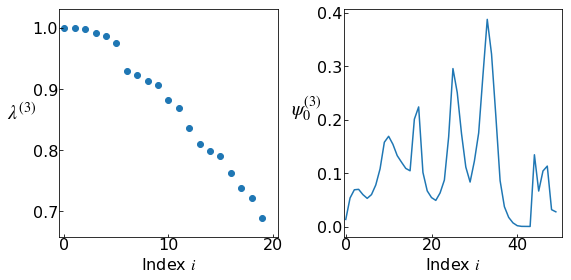

In [13]:
# parameters:
rc_bin['3']=50
# Optimal coefficients of linear combination found by SGOOP
coeff['3']=np.array([-0.03660624, -0.83932822,  0.55682547,  1.45387788,  1.69340439, 1.62443748])

# data:
rc['unbiased']=np.dot(coeff['3'], data_b2[:,200000:300000])
rc['3'] = np.dot(coeff['3'], s['3'])
pi['3'], binedges['3'] = stationary(rc['3'], rc_bin=rc_bin['3'], weights=1/w_arr1/w_arr2)
MU['3'] = mu_factor(rc['unbiased'], pi['3'], binedges['3'], max_d=1)
S['3'] = sg_transmat(rc_bin['3'], pi['3'], MU['3'], max_d=1)
E['3'] = eigenval(S['3'])
eval3, exp_eval3, evec3 = E['3']
rate3 = -eval3

# Plottings:
fig, ax=plt.subplots(figsize=(8,4), nrows=1, ncols=2)

ax[0].scatter(np.arange(exp_eval3.shape[0]-30), exp_eval3[:20])
ax[1].plot(np.abs(E['3'][2][:,0]))

ax[0].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[0].set_xlabel('Index $i$', size=16)
ax[0].set_ylabel('$\lambda^{(3)}$', size=20).set_rotation(0)
ax[0].yaxis.set_label_coords(-0.17, 0.5)
ax[0].set_xlim(-0.5, 20.5)

ax[1].tick_params(which='major', axis='both', direction='in', labelsize=16, pad=1)
ax[1].set_xlabel('Index $i$', size=16)
ax[1].set_ylabel('$\psi^{(3)}_0$', size=20).set_rotation(0)
ax[1].yaxis.set_label_coords(-0.17, 0.5)
ax[1].set_xlim(-0.5,rc_bin['2']+0.5)

fig.tight_layout()
plt.show()

# SGOOP-d

In [14]:
sgd1 = SgoopDistance(coeff['1'], eval1, evec1, binedges['1'])
sgd2 = SgoopDistance(coeff['2'], eval2, evec2, binedges['2'])
sgd3 = SgoopDistance(coeff['3'], eval3, evec3, binedges['3'])

def rate1xd_1(pos1, pos2, num_eig=rc_bin['1']):
    """
    Calculate rate1 * d_comm.
    """
    d_comm1 = sgd1.pairwise_d(pos1, pos2, num_eig)
    
    d_hat1 = rate1[1]*d_comm1
    
    return d_hat1


def rate1xd_2(pos1, pos2, K=1, num_eig=rc_bin['2']):
    """
    Calculate rate1 * d_comm.
    """
    d_comm1 = sgd1.pairwise_d(pos1, pos2, num_eig)
    d_comm2 = sgd2.pairwise_d(pos1, pos2, num_eig)
    
    d_hat1 = rate1[1]*d_comm1
    d_hat2 = rate2[1]*d_comm2
    
    return d_hat1 + K*d_hat2

def rate1xd_3(pos1, pos2, K=1, L=1, num_eig=rc_bin['3']):
    """
    Calculate rate1 * d_comm.
    """
    d_comm1 = sgd1.pairwise_d(pos1, pos2, num_eig)
    d_comm2 = sgd2.pairwise_d(pos1, pos2, num_eig)
    d_comm3 = sgd3.pairwise_d(pos1, pos2, num_eig)
    
    d_hat1 = rate1[1]*d_comm1
    d_hat2 = rate2[1]*d_comm2
    d_hat3 = rate3[1]*d_comm3
    
    return d_hat1 + K*d_hat2 + L*d_hat3

### Determine states we want to look at

In [15]:
def convert_tri(phi1, phi2, phi3):
    return np.hstack(( np.cos(phi1), np.sin(phi1),\
                       np.cos(phi2), np.sin(phi2),\
                       np.cos(phi3), np.sin(phi3) ))

# states
S={}
S[1]=np.array([-1.19 ,0.94, 1.08])
S[2]=np.array([0.94, 0.95, 1.03])
S[3]=np.array([0.97, -1.54, 1.06])
S[4]=np.array([-1.45,-1.57, 1.04])
S[5]=np.array([-1.46 ,1.03, -1.72])
S[6]=np.array([0.98, 1.01, -1.71])
S[7]=np.array([0.95, -1.46, -1.82])
S[8]=np.array([-1.25, -1.45, -1.73])

SS={}
SS_labels={0:'S_1', 1:'S_2', 2:'S_3', 3:'S_4', 4:'S_5', 5:'S_6', 6:'S_7', 7:'S_8'}
SS[0]=convert_tri(*S[1])
SS[1]=convert_tri(*S[2])
SS[2]=convert_tri(*S[3])
SS[3]=convert_tri(*S[4])
SS[4]=convert_tri(*S[5])
SS[5]=convert_tri(*S[6])
SS[6]=convert_tri(*S[7])
SS[7]=convert_tri(*S[8])

# Define pairs to be calculated
num_states=8
SS_pairs=[(i,j) for i in range(num_states) for j in range(i+1,num_states)]
xlabels=['${}$\nto\n${}$'.format(SS_labels[i], SS_labels[j]) for i in range(num_states) for j in range(i+1,num_states)]
num_paths=len(SS_pairs)

### Read estimation of counts of transitions in actual trajectory

In [16]:
res=np.loadtxt('./DATA_alatetra/commits1_8SS.txt')

max_counts=np.zeros(num_paths)
for i in range(num_paths):
    max_counts[i]=np.max(res[i])+1e-3

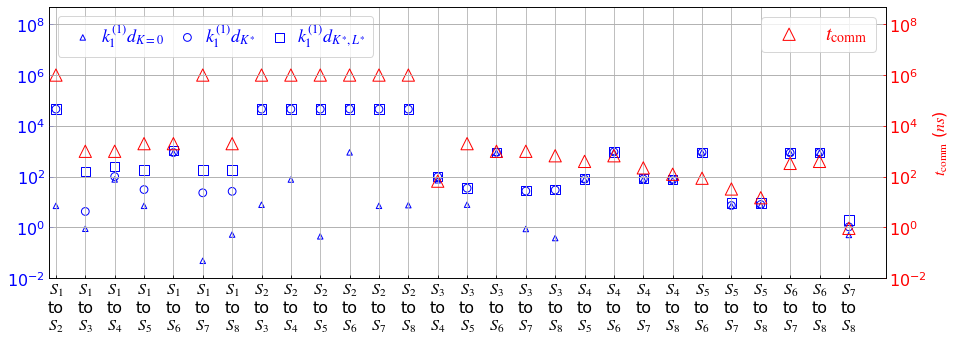

In [17]:
len_traj=1000 # (ns)
K_ast=rate1[1]/rate2[1]
L_ast=rate1[1]/rate3[1]

l=0
kd1=np.zeros(num_paths)
kd2=np.zeros(num_paths)
kd3=np.zeros(num_paths)
for i,j in SS_pairs:
    kd1[l]=rate1xd_1(SS[i],SS[j])
    kd2[l]=rate1xd_2(SS[i],SS[j], K_ast)
    kd3[l]=rate1xd_3(SS[i],SS[j], K_ast, L_ast)
    l+=1
        
# Plottings:
K_arr=np.arange(0,50,1)
fig = plt.figure(figsize=(15,5))
axl = fig.add_subplot(111)
axr = axl.twinx()

axl.scatter(np.arange(kd1.shape[0]), kd1, marker='^', s=30, facecolors='none', edgecolors='b', label='$k^{(1)}_1 d_{K=0}$')
axl.scatter(np.arange(kd2.shape[0]), kd2, marker='o', s=60, facecolors='none', edgecolors='b', label='$k^{(1)}_1 d_{K^{\\ast}}$')
axl.scatter(np.arange(kd3.shape[0]), kd3, marker='s', s=90, facecolors='none', edgecolors='b', label='$k^{(1)}_1 d_{K^{\\ast}, L^{\\ast}}$')
axr.scatter(np.arange(max_counts.shape[0]), len_traj/max_counts, marker='^', s=150, facecolors='none', edgecolors='r', label='$t_{\\rm comm}$')

axl.set_ylim(1e-2,5e+8)
axl.ticklabel_format(axis='y', style='scientific', scilimits=(0,1))
axl.yaxis.offsetText.set_fontsize(16)
axl.yaxis.major.formatter._useMathText = True
axl.set_yscale('log')
axl.tick_params('y', colors='b', which='both', direction='in', labelsize=16)
leg_l = axl.legend(loc='upper left', fontsize=18, ncol=3, handletextpad=0.0, columnspacing=0.3)
for i in range(3): leg_l.get_texts()[i].set_color('b')

axr.set_ylabel('$t_{\\rm comm}$ ($ns$)', color='r', size=16)
axr.set_ylim(1e-2,5e+8)
axr.ticklabel_format(axis='y', style='scientific', scilimits=(0,1))
axr.yaxis.offsetText.set_fontsize(16)
axr.yaxis.major.formatter._useMathText = True
axr.set_yscale('log')
axr.tick_params('y', colors='r', which='both', direction='in', labelsize=16)
leg_r = axr.legend(loc='upper right', fontsize=20)
leg_r.get_texts()[0].set_color('r')

axl.set_xlim(-0.25, num_paths+.25)
axl.set_xticks(np.arange(num_paths))
labels = [item.get_text() for item in axl.get_xticklabels()]
axl.set_xticklabels(xlabels)
axl.tick_params(axis='x', which='both', direction='in', labelsize=16)
axl.grid(axis='y')
axr.grid(axis='y')
axl.grid(axis='x')

plt.show()